In [ ]:
# Credit Card Fraud Detection - Complete Pipeline
!pip install imbalanced-learn scikit-learn pandas numpy matplotlib seaborn opendatasets -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Download dataset from Kaggle
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud'
od.download(dataset_url)

# Load the data
df = pd.read_csv('creditcardfraud/creditcard.csv')

print(f"\n Data loaded successfully!")
print(f"Shape: {df.shape} (rows, columns)")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shruteegurung
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


100%|██████████| 66.0M/66.0M [00:00<00:00, 1.67GB/s]


 Data loaded successfully!
Shape: (284807, 31) (rows, columns)

Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 3 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Clas


 Dataset Overview:
Total Transactions: 284,807
Total Features: 31

 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19   

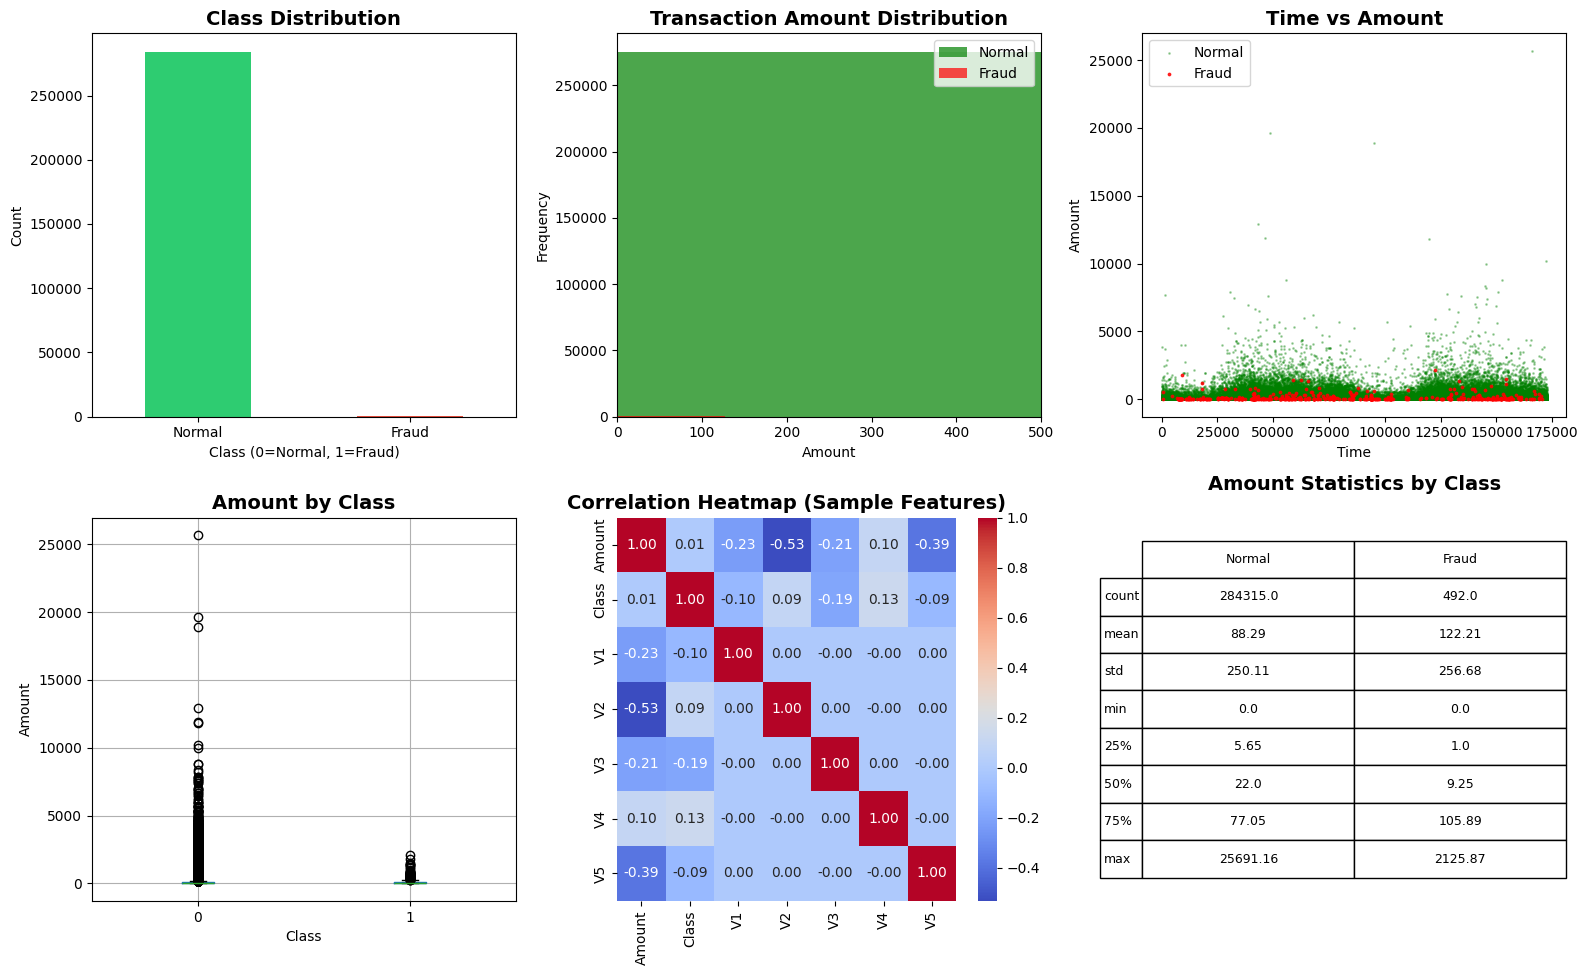

In [ ]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Basic statistics
print("\n Dataset Overview:")
print(f"Total Transactions: {len(df):,}")
print(f"Total Features: {df.shape[1]}")
print(f"\n Data Info:")
print(df.info())

print("\n Statistical Summary:")
print(df.describe())

print("\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print(" No missing values!")
else:
    print(missing[missing > 0])

# Class distribution
print("\n Class Distribution:")
print(df['Class'].value_counts())
print(f"\nPercentage Distribution:")
class_dist = df['Class'].value_counts(normalize=True) * 100
print(f"Normal transactions: {class_dist[0]:.2f}%")
print(f"Fraudulent transactions: {class_dist[1]:.2f}%")

fraud_ratio = (df['Class'].sum() / len(df)) * 100
print(f"\n Fraud Ratio: {fraud_ratio:.3f}% (Highly Imbalanced Dataset!)")

# Visualizations
fig = plt.figure(figsize=(16, 10))

# 1. Class Distribution
ax1 = plt.subplot(2, 3, 1)
df['Class'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax1)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class (0=Normal, 1=Fraud)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Normal', 'Fraud'], rotation=0)

# 2. Transaction Amount Distribution
ax2 = plt.subplot(2, 3, 2)
ax2.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.7, label='Normal', color='green')
ax2.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='red')
ax2.set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.set_xlim([0, 500])

# 3. Time Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(df[df['Class']==0]['Time'], df[df['Class']==0]['Amount'],
           alpha=0.3, s=1, label='Normal', c='green')
ax3.scatter(df[df['Class']==1]['Time'], df[df['Class']==1]['Amount'],
           alpha=0.8, s=3, label='Fraud', c='red')
ax3.set_title('Time vs Amount', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amount')
ax3.legend()

# 4. Box plot for Amount
ax4 = plt.subplot(2, 3, 4)
df.boxplot(column='Amount', by='Class', ax=ax4)
ax4.set_title('Amount by Class', fontsize=14, fontweight='bold')
ax4.set_xlabel('Class')
ax4.set_ylabel('Amount')
plt.suptitle('')

# 5. Correlation heatmap (sample)
ax5 = plt.subplot(2, 3, 5)
corr_features = ['Amount', 'Class'] + [f'V{i}' for i in range(1, 6)]
corr = df[corr_features].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax5, cbar=True)
ax5.set_title('Correlation Heatmap (Sample Features)', fontsize=14, fontweight='bold')

# 6. Fraud vs Normal Statistics
ax6 = plt.subplot(2, 3, 6)
stats_data = pd.DataFrame({
    'Normal': df[df['Class']==0]['Amount'].describe(),
    'Fraud': df[df['Class']==1]['Amount'].describe()
})
ax6.axis('tight')
ax6.axis('off')
table = ax6.table(cellText=stats_data.values.round(2),
                 rowLabels=stats_data.index,
                 colLabels=stats_data.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax6.set_title('Amount Statistics by Class', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [ ]:
# FEATURE ENGINEERING


# Create a copy for feature engineering
df_engineered = df.copy()

# Feature 1: Amount bins
df_engineered['Amount_Bin'] = pd.cut(df_engineered['Amount'],
                                      bins=[0, 50, 200, 500, np.inf],
                                      labels=['Low', 'Medium', 'High', 'Very High'])
df_engineered['Amount_Bin'] = df_engineered['Amount_Bin'].astype('category').cat.codes

# Feature 2: Time-based features (assuming Time is in seconds)
df_engineered['Hour'] = (df_engineered['Time'] / 3600) % 24
df_engineered['Is_Night'] = ((df_engineered['Hour'] >= 22) | (df_engineered['Hour'] <= 6)).astype(int)

# Feature 3: Log transformation of Amount (avoid log(0))
df_engineered['Amount_Log'] = np.log1p(df_engineered['Amount'])

# Feature 4: Interaction features with V features
df_engineered['V1_Amount'] = df_engineered['V1'] * df_engineered['Amount']
df_engineered['V2_Amount'] = df_engineered['V2'] * df_engineered['Amount']

print("✓ Feature engineering completed!")
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"\nNew features added:")
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(new_features)

✓ Feature engineering completed!
Original features: 31
Engineered features: 37

New features added:
['Amount_Bin', 'Hour', 'Is_Night', 'Amount_Log', 'V1_Amount', 'V2_Amount']


In [ ]:
#  DATA SPLITTING

# Separate features and target
X = df_engineered.drop('Class', axis=1)
y = df_engineered['Class']

# Split into train+validation (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split train+validation into train (75% of 80% = 60%) and validation (25% of 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"✓ Data split completed!")
print(f"\nDataset sizes:")
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nClass distribution in each set:")
print(f"Training   - Fraud: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.3f}%)")
print(f"Validation - Fraud: {y_val.sum():,} ({y_val.sum()/len(y_val)*100:.3f}%)")
print(f"Test       - Fraud: {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.3f}%)")

✓ Data split completed!

Dataset sizes:
Training set:   170,883 samples (60.0%)
Validation set: 56,962 samples (20.0%)
Test set:       56,962 samples (20.0%)

Class distribution in each set:
Training   - Fraud: 295 (0.173%)
Validation - Fraud: 99 (0.174%)
Test       - Fraud: 98 (0.172%)


In [ ]:
# FEATURE SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(" Feature scaling completed using StandardScaler!")

 Feature scaling completed using StandardScaler!


In [ ]:
# HANDLE CLASS IMBALANCE WITH SMOTE

print(f"Before SMOTE - Training set:")
print(f"Normal: {(y_train==0).sum():,}, Fraud: {(y_train==1).sum():,}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE - Training set:")
print(f"Normal: {(y_train_balanced==0).sum():,}, Fraud: {(y_train_balanced==1).sum():,}")
print("SMOTE applied successfully!")

Before SMOTE - Training set:
Normal: 170,588, Fraud: 295

After SMOTE - Training set:
Normal: 170,588, Fraud: 170,588
SMOTE applied successfully!


In [ ]:
# MODEL TRAINING

# Dictionary to store models and results
models = {}
results = {}

# Define models
models_config = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

print("Training models on balanced dataset...\n")

for name, model in models_config.items():
    print(f" Training {name}...")

    # Train model
    model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Store model and predictions
    models[name] = {
        'model': model,
        'val_pred': y_val_pred,
        'val_proba': y_val_proba
    }

    print(f"   {name} trained successfully!")

print("\n All models trained!")

Training models on balanced dataset...

 Training Logistic Regression...
   Logistic Regression trained successfully!
 Training Decision Tree...
   Decision Tree trained successfully!
 Training Random Forest...
   Random Forest trained successfully!
 Training Gradient Boosting...
   Gradient Boosting trained successfully!
 Training XGBoost...
   XGBoost trained successfully!

 All models trained!


In [ ]:
# MODEL EVALUATION ON VALIDATION SET

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Evaluate model and return metrics"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba)
    }
    return metrics

# Evaluate all models
eval_results = []

for name, model_dict in models.items():
    metrics = evaluate_model(y_val, model_dict['val_pred'],
                           model_dict['val_proba'], name)
    eval_results.append(metrics)
    results[name] = metrics

# Create results dataframe
results_df = pd.DataFrame(eval_results)
results_df = results_df.round(4)

print("\n VALIDATION RESULTS:")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\n Best Model (by F1-Score): {best_model_name}")


 VALIDATION RESULTS:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
Logistic Regression    0.9741     0.0550  0.8586    0.1034   0.9707  0.6866
      Decision Tree    0.9975     0.3807  0.6768    0.4873   0.8374  0.2582
      Random Forest    0.9994     0.8837  0.7677    0.8216   0.9572  0.7993
  Gradient Boosting    0.9903     0.1339  0.8384    0.2309   0.9716  0.7412
            XGBoost    0.9994     0.8556  0.7778    0.8148   0.9723  0.8101

 Best Model (by F1-Score): Random Forest


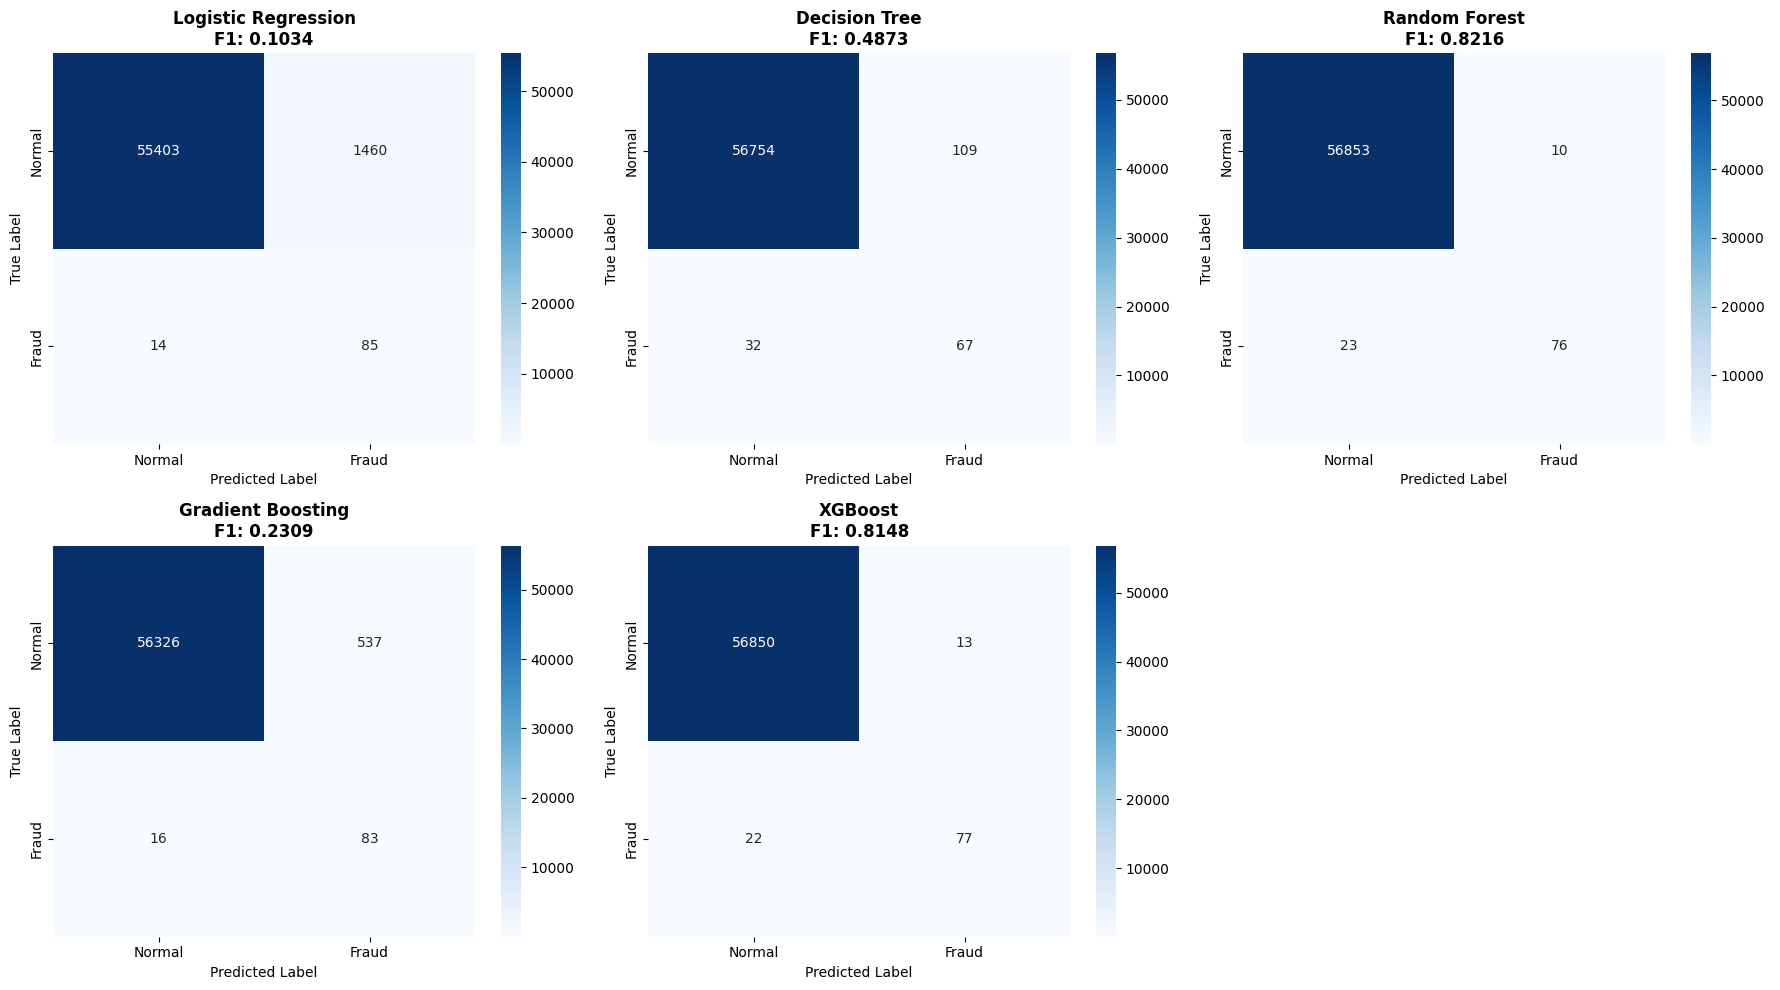

In [ ]:
# CONFUSION MATRICES

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, model_dict) in enumerate(models.items()):
    cm = confusion_matrix(y_val, model_dict['val_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'])
    axes[idx].set_title(f'{name}\nF1: {results[name]["F1-Score"]:.4f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

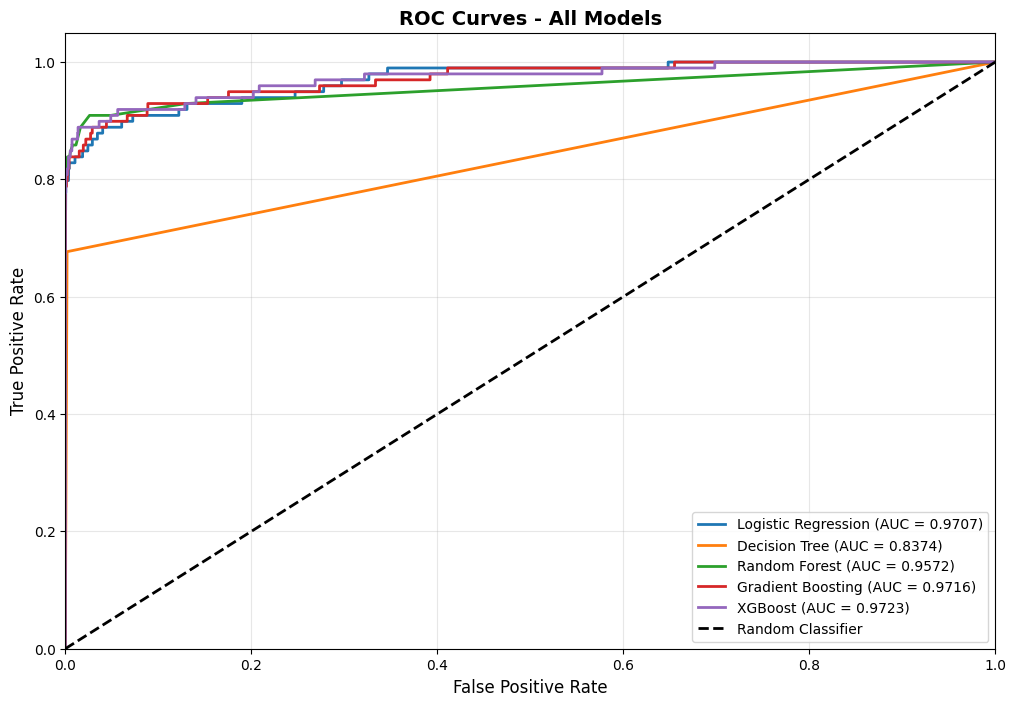

In [ ]:
# ROC CURVES

plt.figure(figsize=(12, 8))

for name, model_dict in models.items():
    fpr, tpr, _ = roc_curve(y_val, model_dict['val_proba'])
    auc = results[name]['ROC-AUC']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

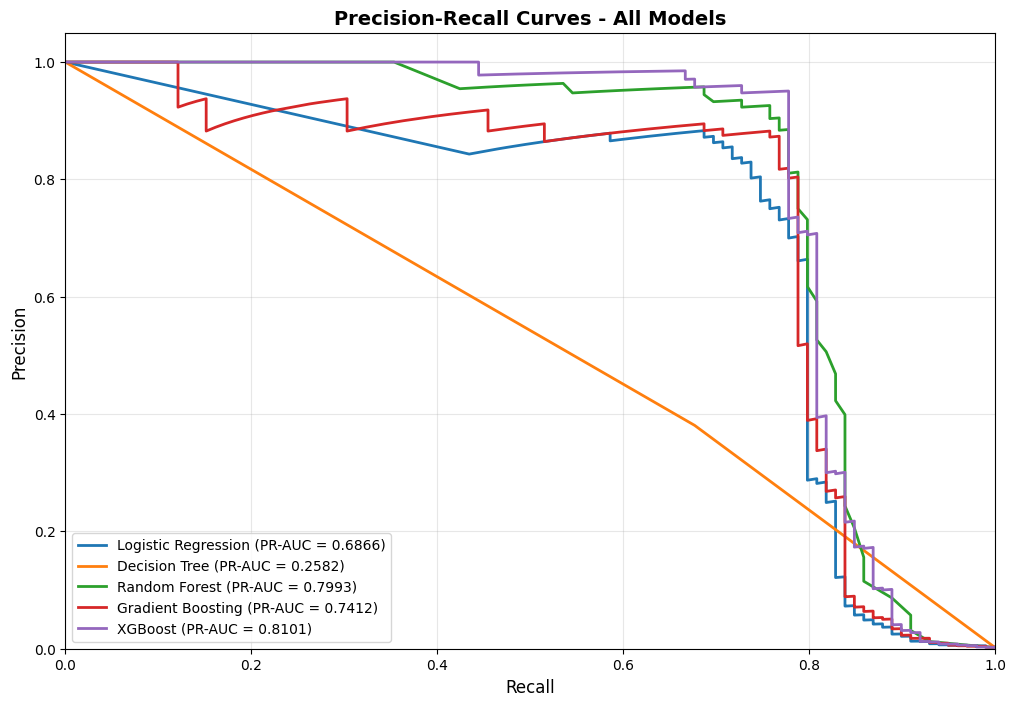

In [ ]:
# PRECISION-RECALL CURVES

plt.figure(figsize=(12, 8))

for name, model_dict in models.items():
    precision, recall, _ = precision_recall_curve(y_val, model_dict['val_proba'])
    pr_auc = results[name]['PR-AUC']
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.4f})", linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.show()